# Tâches à faire



Le but de ce travail est de comprendre et préparer les données dans CouponRecommendation.csv

Les tâches à réaliser sont:

0. Comprendre la structure des données et l'impact potentiel d'un modèle prédictif basé sur ces données sur les opérations de l'entreprise.

1. Explorer et visualiser l'ensemble de données pour comprendre et identifier ses éventuelles anomalies.

2. Appliquer des techniques de nettoyage et de transformation des données pour résoudre ces problèmes : <br>
   a. Traiter les valeurs manquantes si elles existent, <br>
   b. Corriger et traiter les valeurs aberrantes, <br>
   c. Transformez les caractéristiques catégorielles si nécessaire. <br>
   d. Transformer les caractéristiques numériques pour améliorer les propriétés de distribution, <br>
   e. Appliquer des techniques d'ingénierie de fonctionnalités, si nécessaire, <br>
   f. etc.

**Deliverables:** Detailed notebook presenting Business understanding, data understanding, data exploration and data preparation techniques and a csv file containing prepared and cleaned data. (10 minutes)

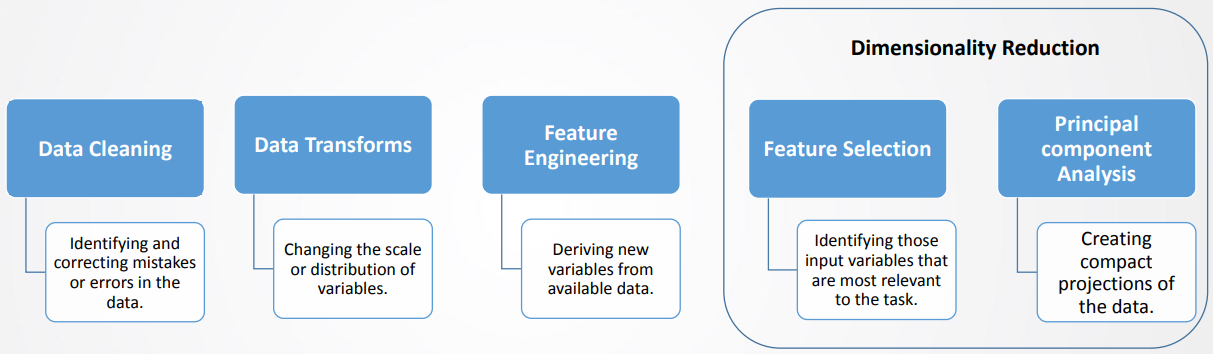

# Useful functions

In [ ]:
import plotly.graph_objects as go
from scipy.stats import chi2_contingency
from plotly.subplots import make_subplots
from scipy.stats.contingency import association

In [ ]:
# Count the probability of acceptance for each unique value in the column.
def probability(df, col):
    # Count 'Y=1' occurrences for each unique value in the column.
    yes_man = df.loc[(df['Y'] == 1), col].value_counts()
    # Count total occurrences for each unique value in the column.
    value_counts = df[col].value_counts()

    # Get unique values in the column.
    val_index = value_counts.index

    # Calculate the ratio of 'Y=1' occurrences for each unique value.
    ratio_yes = yes_man / value_counts

    return val_index, ratio_yes * 100


# Create a DataFrame with a new column indicating whether the value is in the given list.
def income_output(df, li, col):
    temp_df = df[[col, 'Y']].copy()
    # Add a new column indicating whether the value is in the specified list.
    temp_df['high_acc'] = temp_df[col].apply(lambda x: x in li)

    return temp_df


# Return indices of sorted probabilities after applying a threshold.
def descending_withThresh(prob, thresh):
    return prob.sort_values(ascending=False).iloc[:-thresh].index


# Analyze the relationship between the specified column and the target variable 'Y'.
def get_higher_variable(df, col):
    # Calculate acceptance probability for each unique value in the column.
    idx, prob = probability(df, col)
    # Initialize a dictionary to store p-values and Cramér's V values.
    thresh_result = {'p-value': [], 'crammer_v': []}
    # Create a list of thresholds.
    thresh_li = [x for x in range(1, len(prob) + 1)]

    # Sort probabilities in descending order.
    desc_result = prob.sort_values(ascending=False)

    # Iterate over thresholds.
    for i in thresh_li:
        # Get indices of sorted probabilities after applying the threshold.
        high_acc = descending_withThresh(desc_result, i)

        # Create a DataFrame with a new column based on the threshold.
        df_res = income_output(df.copy(), high_acc, col)

        # Create a contingency table and calculate p-value and Cramér's V.
        cont = pd.crosstab(df_res['high_acc'], df_res['Y'])
        correlation = chi2_contingency(cont)[1]
        assoc = association(cont, method='cramer')

        # Append p-value and Cramér's V to the dictionary.
        thresh_result['p-value'].append(correlation)
        thresh_result['crammer_v'].append(assoc)

    # Create a DataFrame from the dictionary and filter based on significance level.
    result_df = pd.DataFrame(thresh_result, index=thresh_li)
    result_df = result_df[result_df['p-value'] < 0.01]

    # Find the threshold with the maximum Cramér's V.
    max_thresh_index = result_df[result_df['crammer_v'] == result_df['crammer_v'].max()].index[0]
    # Get the descending order of probabilities after applying the maximum Cramér's V threshold.
    max_filtered = descending_withThresh(desc_result, max_thresh_index)

    return result_df, descending_withThresh(desc_result, max_thresh_index), desc_result[max_filtered]


# Data understanding

*   Ce jeu de données est un ensemble de données sur la recommandation de coupons en voiture. Il contient des informations sur le profil, le contexte et les préférences des utilisateurs qui reçoivent des coupons pour des restaurants, des cafés ou des bars.

*   On cherche à préparer les données pour ensuite créer des modèles permettant de prédire si un utilisateur acceptera ou rejettera un coupon en fonction de ses attributs démographiques et contextuels. Cela peut aider l’entreprise à offrir le bon coupon au bon client et à augmenter son chiffre d’affaires.



The dataset consists of over 12684 data points and 26 attributes, most of the attributes are categorical and some attributes are numeric-categorical types.

Explanation of Dataset attributes/features:

**User attributes:**

1. **Gender:** Female, Male
2. **Age:** 21, 46, 26, 31, 41, 50plus, 36, below21
3. **Marital Status:** Unmarried partner, Single, Married partner, Divorced, Widowed
4. **has_Children:** 1: has children, 0: No children
5. **Education:** Some college — no degree, Bachelors degree, Associates degree, High School Graduate, Graduate degree (Masters or Doctorate), Some High School
6. **Occupation:** 25 unique occupations (Unemployed, Architecture & Engineering, Student,Education&Training&Library, Healthcare Support,Healthcare Practitioners & Technical, Sales & Related, Management,Arts Design Entertainment Sports & Media, Computer & Mathematical,Life Physical Social Science, Personal Care & Service, Community & Social Services, Office & Administrative Support, Construction & Extraction, Legal, Retired, Installation Maintenance & Repair, Transportation & Material Moving, Business & Financial, Protective Service, Food Preparation & Serving Related, Production Occupations, Building & Grounds Cleaning & Maintenance, Farming Fishing & Forestry)
7. **Income:** income of user (Less than \$12500,\$12500 — \$24999,\$25000 — \$37499,\$37500 — \$49999,\$50000 — \$62499,\$62500 — \$74999,\$75000 — \$87499,\$87500 — \$99999,\$100000 or More)
8. **Car :** Description of vehicle which driven by user (Scooter and motorcycle, crossover, Mazda5) (99% of values are missing in this feature)
9. **Bar:** how many times does the user go to a bar every month? (never, less1, 1\~3, 4\~8, gt8, nan)
10. **CoffeeHouse:** how many times does the user go to a coffeehouse every month? (never, less1, 1\~3, 4\~8, gt8, nan)
11. **CarryAway:** how many times does the user get take-away food every month? (never, less1, 1\~3, 4\~8, gt8, nan)
12. **RestaurantLessThan20:** how many times does the user go to a restaurant with an average expense per person of less than  \$20 every month? (never, less1, 1\~3, 4\~8, gt8, nan)
13. **Restaurant20To50:** how many times does the user go to a restaurant with average expense per person of \$20 — \$50 every month? (never, less1, 1\~3, 4\~8, gt8, nan)

**Contextual attributes:**

1. **Destination:** destination of user (No Urgent Place, Home, Work)
2. **Passenger:** who are the passengers in the car (Alone, Friend(s), Kid(s), Partner)
3. **Weather:** weather when user is driving (Sunny, Rainy, Snowy)
4. **Temperature:** temperature in Fahrenheit when user is driving (55, 80, 30)
5. **Time:** the time when the user is driving (2PM, 10AM, 6PM, 7AM, 10PM)
6. **toCoupon_GEQ5min:** driving distance to the restaurant/cafe/bar for using the coupon is greater than 5 minutes (0,1)
7. **toCoupon_GEQ15min:** driving distance to the restaurant/cafe/bar for using the coupon is greater than 15 minutes (0,1)
8. **toCoupon_GEQ25min:** driving distance to the restaurant/cafe/bar for using the coupon is greater than 25 minutes (0,1)
9. **direction_same:** whether the restaurant/cafe/bar is in the same direction as user’s current destination (0,1)
10. **direction_opp:** whether the restaurant/cafe/bar is in the opposite direction as user’s current destination (0,1)

**Coupon attributes:**

1. **Coupon:** coupon type offered by company (Restaurant(<\$20), Coffee House, Carry out & Take away, Bar, Restaurant(\$20-\$50))
Here, <\$20 is the average pay per user in a not too expensive restaurant, Restaurant(\$20-\$50) means the average pay per user is between \$20 to \$50 which little bit expensive restaurant.
2. **Expiration:** coupon expires in 1 day or in 2 hours (1d, 2h)

**Target attribute:**

1. Y: whether the coupon is accepted or rejected, 1:accepted, 0:rejected (**supervisé**)

# Business understanding

Nous cherchons à prédir si un client acceptera ou rejettera le coupon proposé en fonction du profil et de l'historique du client.

Cette prédiction aide l'entreprise à proposer un coupon adéquat, favorisant ainsi l'utilisation accrue de ses services par les clients et générant davantage de transactions pour l'entreprise.

L'objectif est de prédire si un client acceptera ou rejettera le coupon pour un lieu spécifique en fonction d'attributs démographiques et contextuels.

C'est un problème de classification de classes binaires.

* Contraintes métier :
un nombre minimal de points mal classés est requis.



Si on se réfère à l'approche **CRISP-DM**, l'objectif de ce travail consisterait à réaliser les trois premières phases :

1.   **Compréhension du projet :** identification des objectifs commerciaux et des objectifs du projet.
2.   **Exploration des données :** exploration des données disponibles, identification des problèmes de qualité des données et sélection des données pertinentes pour l'analyse.
3.  **Ingénierie des caractéristiques :** préparation et transformation des données en vue de leur utilisation dans le modèle de recommandation de coupons et nettoyage des données.

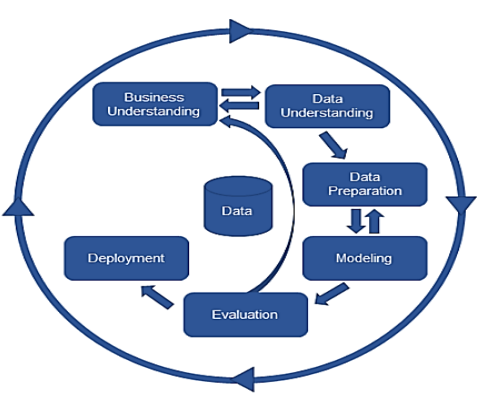

# Data Exploration

**Explorer et visualiser**

In [ ]:
from google.colab import files
from pandas.core.frame import DataFrame
from math import ceil
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# warnings.filterwarnings("ignore")

In [ ]:
# sns.set_theme(style="ticks", color_codes=True)
sns.set_theme(style="whitegrid")

In [ ]:
# uploaded_dataset = files.upload()

In [ ]:
# data = pd.read_csv(io.BytesIO(uploaded_dataset['CouponRecommendation.csv']))

In [ ]:
data = pd.read_csv('CouponRecommendation.csv')

In [ ]:
data

,destination,passanger,weather,temperature,time,coupon,expiration,gender,age,maritalStatus,...,CoffeeHouse,CarryAway,RestaurantLessThan20,Restaurant20To50,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
0,No Urgent Place,Alone,Sunny,55,2PM,Restaurant(<20),1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,1
1,No Urgent Place,Friend(s),Sunny,80,10AM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,0,0,0,1,0
2,No Urgent Place,Friend(s),Sunny,80,10AM,Carry out & Take away,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,1
3,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,2h,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
4,No Urgent Place,Friend(s),Sunny,80,2PM,Coffee House,1d,Female,21,Unmarried partner,...,never,NaN,4~8,1~3,1,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12679,Home,Partner,Rainy,55,6PM,Carry out & Take away,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,0,0,1,0,1
12680,Work,Alone,Rainy,55,7AM,Carry out & Take away,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,0,0,0,1,1
12681,Work,Alone,Snowy,30,7AM,Coffee House,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,0,0,1,0,0
12682,Work,Alone,Snowy,30,7AM,Bar,1d,Male,26,Single,...,never,1~3,4~8,1~3,1,1,1,0,1,0


In [ ]:
print(data.shape)
print('Number of datapoints: ', data.shape[0])
print('Number of features: ', data.shape[1])

(12684, 26)
Number of datapoints:  12684
Number of features:  26


Ce dataset contient 12684 observations et 26 colonnes: un total de 12684 x 26 datapoints.

In [ ]:
data.columns

Index(['destination', 'passanger', 'weather', 'temperature', 'time', 'coupon',
       'expiration', 'gender', 'age', 'maritalStatus', 'has_children',
       'education', 'occupation', 'income', 'car', 'Bar', 'CoffeeHouse',
       'CarryAway', 'RestaurantLessThan20', 'Restaurant20To50',
       'toCoupon_GEQ5min', 'toCoupon_GEQ15min', 'toCoupon_GEQ25min',
       'direction_same', 'direction_opp', 'Y'],
      dtype='object')

In [ ]:
# Unique values
print(data['Bar'].value_counts())
print(data['passanger'].value_counts())
print(data['age'].value_counts())
print(data['income'].value_counts())

never    5197
less1    3482
1~3      2473
4~8      1076
gt8       349
Name: Bar, dtype: int64
Alone        7305
Friend(s)    3298
Partner      1075
Kid(s)       1006
Name: passanger, dtype: int64
21         2653
26         2559
31         2039
50plus     1788
36         1319
41         1093
46          686
below21     547
Name: age, dtype: int64
$25000 - $37499     2013
$12500 - $24999     1831
$37500 - $49999     1805
$100000 or More     1736
$50000 - $62499     1659
Less than $12500    1042
$87500 - $99999      895
$75000 - $87499      857
$62500 - $74999      846
Name: income, dtype: int64


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12684 entries, 0 to 12683
Data columns (total 26 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   destination           12684 non-null  object
 1   passanger             12684 non-null  object
 2   weather               12684 non-null  object
 3   temperature           12684 non-null  int64 
 4   time                  12684 non-null  object
 5   coupon                12684 non-null  object
 6   expiration            12684 non-null  object
 7   gender                12684 non-null  object
 8   age                   12684 non-null  object
 9   maritalStatus         12684 non-null  object
 10  has_children          12684 non-null  int64 
 11  education             12684 non-null  object
 12  occupation            12684 non-null  object
 13  income                12684 non-null  object
 14  car                   108 non-null    object
 15  Bar                   12577 non-null

In [ ]:
data.select_dtypes('int64').nunique()

temperature          3
has_children         2
toCoupon_GEQ5min     1
toCoupon_GEQ15min    2
toCoupon_GEQ25min    2
direction_same       2
direction_opp        2
Y                    2
dtype: int64

All numeric features have 3, 2 or 1 unique values only. Encoding them is necessary.

- Temperature is an ordinal feature
-**toCoupon_GEQ5min has only one value**
- The rest are binary categorical-numerical values

La plupart des features sont catégorielles. Quelques-unes sont de types catégoriels-numériques.

Certaines features ont des valeurs nulles. On doit alors verifier le taux des valeurs manquantes et peut-être les imputer aprés avoir consulter un expert.

In [ ]:
# data.describe(include='all')
data.describe()

,temperature,has_children,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
count,12684.000000,12684.000000,12684.0,12684.000000,12684.000000,12684.000000,12684.000000,12684.000000
mean,63.301798,0.414144,1.0,0.561495,0.119126,0.214759,0.785241,0.568433
std,19.154486,0.492593,0.0,0.496224,0.323950,0.410671,0.410671,0.495314
min,30.000000,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,55.000000,0.000000,1.0,0.000000,0.000000,0.000000,1.000000,0.000000
50%,80.000000,0.000000,1.0,1.000000,0.000000,0.000000,1.000000,1.000000
75%,80.000000,1.000000,1.0,1.000000,0.000000,0.000000,1.000000,1.000000
max,80.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# Change Object datatypes to category datatype

# df_obj = data.select_dtypes(include=['object'])
# data[df_obj.columns] = df_obj.astype('category')
# print(data.dtypes)

En convertissant les colonnes de type objet en category, nous réduisons l'empreinte mémoire, accélérons les opérations de traitement de données et simplifions l'analyse.

In [ ]:
Y_count = data.groupby('Y').Y.count()
print('Accepted coupons:', Y_count[1], round(Y_count[1] / data.shape[0] * 100, 3), '%')
print('Rejected coupons:', Y_count[0], round(Y_count[0] / data.shape[0] * 100, 3), '%')

Accepted coupons: 7210 56.843 %
Rejected coupons: 5474 43.157 %


Il s'agit d'un jeu de données **plus ou moins équilibré**: les différentes classes au sein de l'ensemble de données sont représentées de manière similaire ou presque égale. En d'autres termes, il n'y a pas de déséquilibre marqué dans la répartition des différentes classes.

Si un ensemble de données est déséquilibré, cela peut entraîner un **biais** dans le modèle, car il peut favoriser les classes majoritaires et sous-représenter les classes minoritaires, ce qui peut affecter la capacité du modèle à généraliser et à fournir des prédictions précises pour toutes les classes.

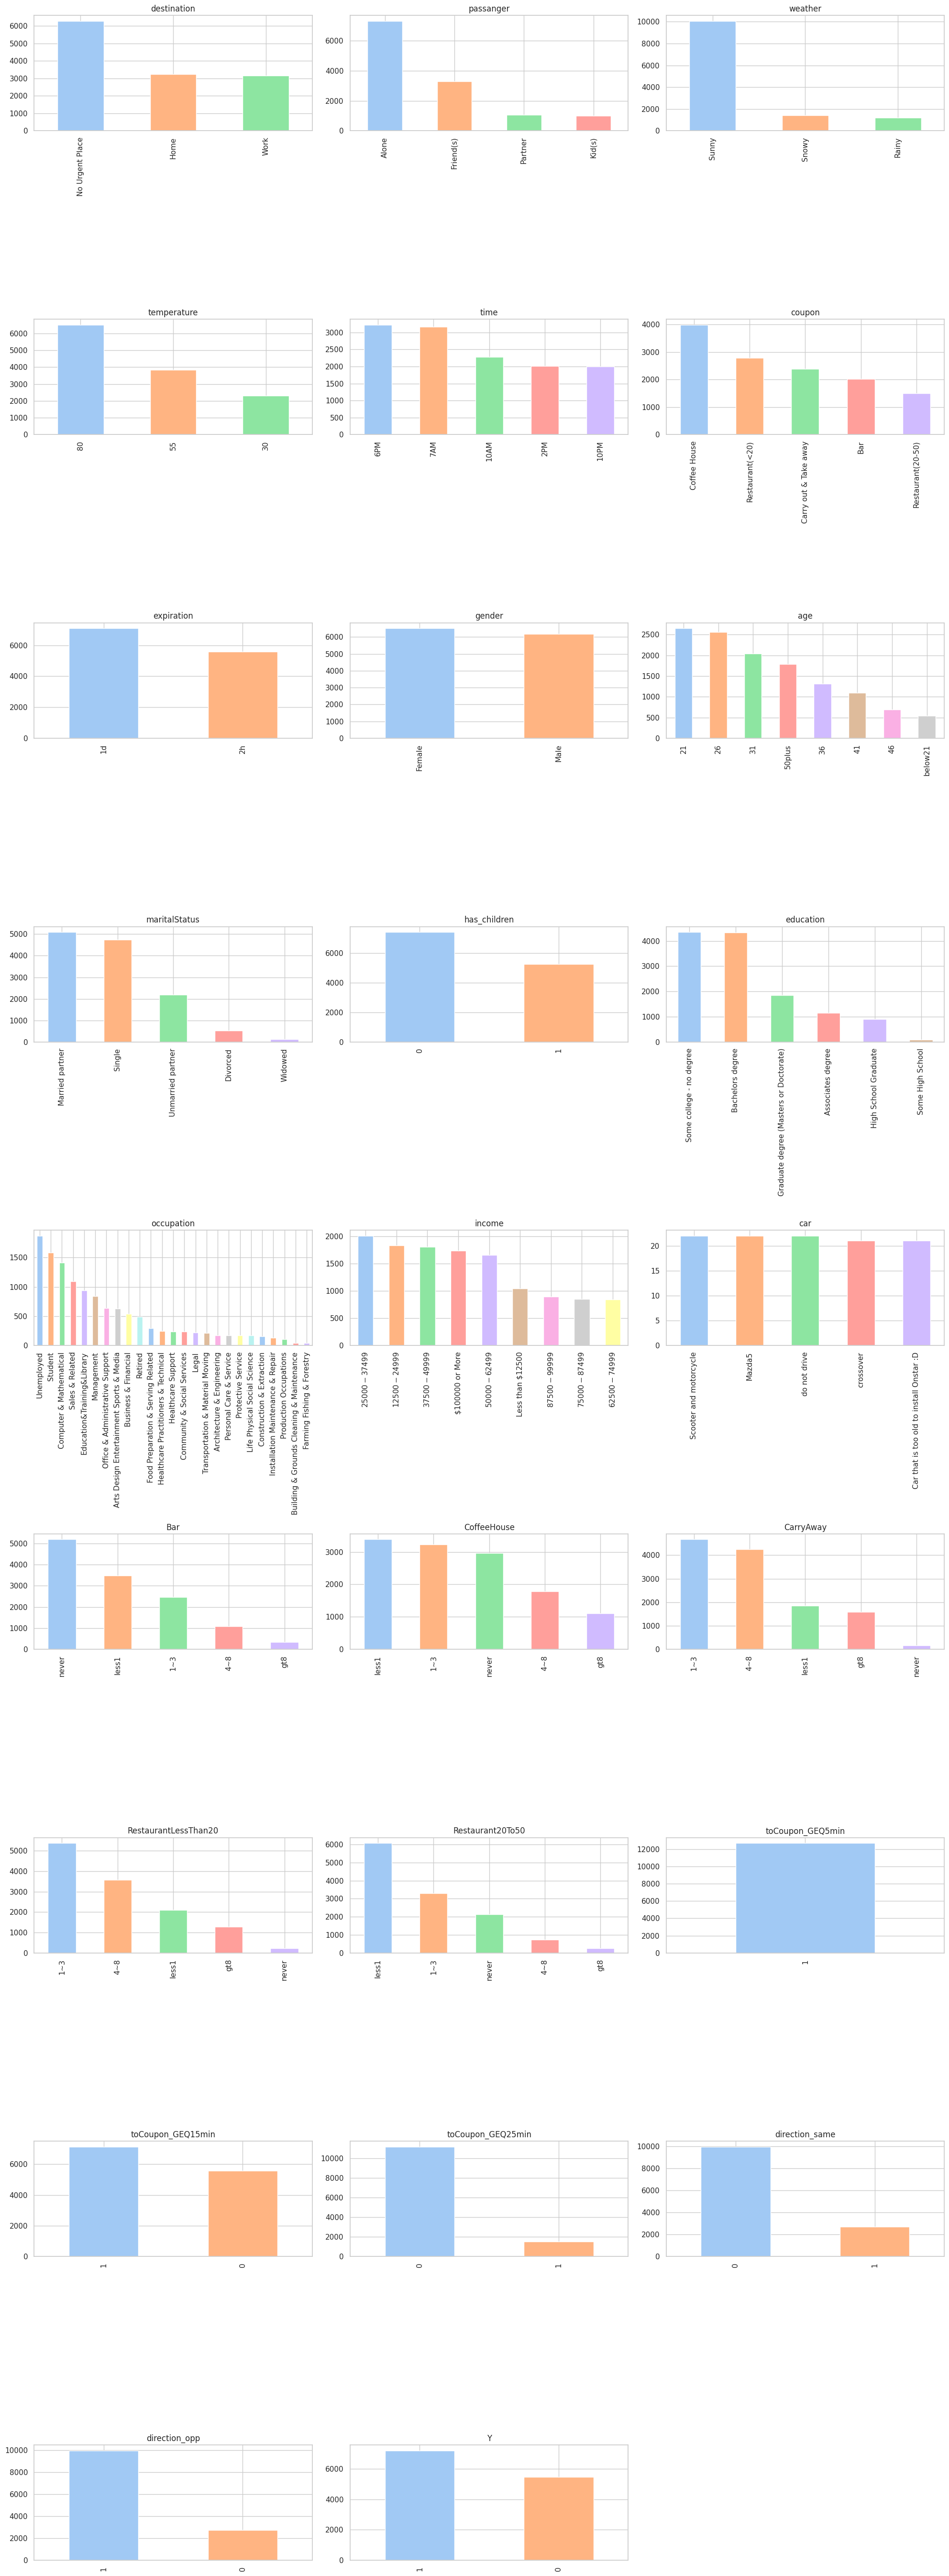

In [ ]:
num_cols = 3
num_rows = ceil(len(data.columns) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 6 * num_rows))
axes = axes.flatten()

pastel_colors = sns.color_palette("pastel")

for col, ax in zip(data.columns, axes):
    data[col].value_counts().plot(kind='bar', ax=ax, color=pastel_colors)
    ax.set_title(col)

# Hide unused subplots
for j in range(len(data.columns), num_rows * num_cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

- Most of the numeric value in the dataset are either 0 or 1, except the temperature.



In [ ]:
corr_matrix = data.corr()
corr_matrix

<ipython-input-18-b20f780b4413>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data.corr()


,temperature,has_children,toCoupon_GEQ5min,toCoupon_GEQ15min,toCoupon_GEQ25min,direction_same,direction_opp,Y
temperature,1.000000,-0.019716,NaN,-0.155332,-0.216254,0.097085,-0.097085,0.061240
has_children,-0.019716,1.000000,NaN,0.078211,-0.013722,-0.031620,0.031620,-0.045557
toCoupon_GEQ5min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
toCoupon_GEQ15min,-0.155332,0.078211,NaN,1.000000,0.324984,-0.303533,0.303533,-0.081602
toCoupon_GEQ25min,-0.216254,-0.013722,NaN,0.324984,1.000000,-0.192319,0.192319,-0.103633
direction_same,0.097085,-0.031620,NaN,-0.303533,-0.192319,1.000000,-1.000000,0.014570
direction_opp,-0.097085,0.031620,NaN,0.303533,0.192319,-1.000000,1.000000,-0.014570
Y,0.061240,-0.045557,NaN,-0.081602,-0.103633,0.014570,-0.014570,1.000000


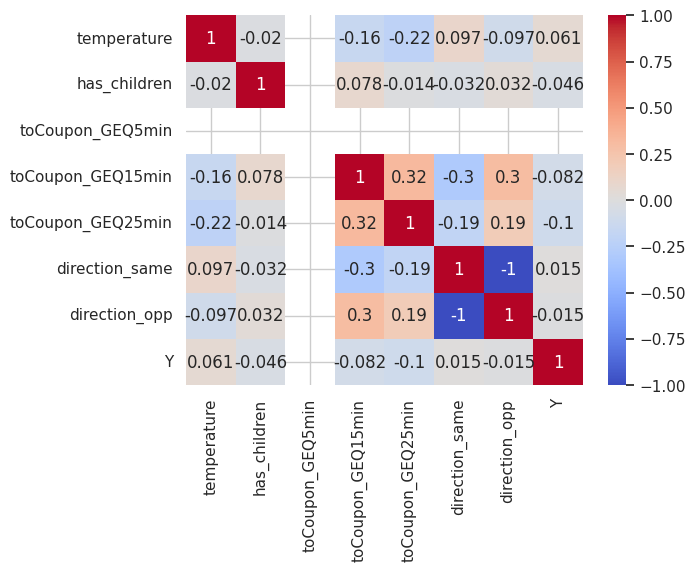

In [ ]:
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
plt.show()

- The feature *direction_same* is perfectly correlated with *direction_opp*: both have the same variance.

- *toCoupon_GEQ5min* feature has no correlation with any feature because it has the same value 1 for all data points, which means all the restaurants/bars are at least more than five minutes away from the driver.

We'll drop both *direction_opp* and *toCoupon_GEQ5min*.

In [ ]:
data.drop(columns=['direction_opp'], inplace=True)

In [ ]:
data.select_dtypes('int64').nunique()

temperature          3
has_children         2
toCoupon_GEQ5min     1
toCoupon_GEQ15min    2
toCoupon_GEQ25min    2
direction_same       2
Y                    2
dtype: int64

In [ ]:
data.drop(columns=['toCoupon_GEQ5min'], inplace=True)

In [ ]:
# Analysis of direction_same

# Create a DataFrame for analysis of the 'direction_same' feature
df_direction = pd.DataFrame(sorted(list(data['direction_same'].unique())), columns=['direction_same'])

# Calculate total counts and percentages
df_direction['Total_Count'] = data.groupby('direction_same').Y.count()
df_direction['Total_%'] = round(df_direction['Total_Count'] / data['direction_same'].shape[0] * 100, 3)

# Calculate counts of accepted and rejected instances
df_direction['Accepted'] = data[data.Y == 1].groupby('direction_same').Y.count()
df_direction['Rejected'] = data[data.Y == 0].groupby('direction_same').Y.count()

# Calculate percentage of accepted and rejected instances
df_direction['%Accepted'] = round(df_direction['Accepted'] / df_direction['Total_Count'] * 100, 3)
df_direction['%Rejected'] = round(df_direction['Rejected'] / df_direction['Total_Count'] * 100, 3)

df_direction

,direction_same,Total_Count,Total_%,Accepted,Rejected,%Accepted,%Rejected
0,0,9960,78.524,5624,4336,56.466,43.534
1,1,2724,21.476,1586,1138,58.223,41.777


- 78% of *direction_same*'s data points are '0', 22% are '1'.
Both have similar acceptance and rejection ratios
=> this feature has no predictive power.

We'll drop the *direction_same* feature.

In [ ]:
data.drop(columns=['direction_same'], inplace=True)

In [ ]:
# Analysis of the temperature feature

# Calculate total counts for all 'temperature' values
total_counts = data.groupby('temperature').Y.count().reset_index()
total_counts.columns = ['temperature', 'Total_Count']

# Calculate counts of accepted and rejected instances
accepted_counts = data[data.Y == 1].groupby('temperature').Y.count().reset_index()
accepted_counts.columns = ['temperature', 'Accepted']

rejected_counts = data[data.Y == 0].groupby('temperature').Y.count().reset_index()
rejected_counts.columns = ['temperature', 'Rejected']

# Merge the results into a single DataFrame
result_df = pd.concat([total_counts, accepted_counts['Accepted'], rejected_counts['Rejected']], axis=1)

# Add columns for percentages of accepted and rejected
result_df['%Accepted'] = round(result_df['Accepted'] / result_df['Total_Count'] * 100, 2)
result_df['%Rejected'] = round(result_df['Rejected'] / result_df['Total_Count'] * 100, 2)

result_df

,temperature,Total_Count,Accepted,Rejected,%Accepted,%Rejected
0,30,2316,1230,1086,53.11,46.89
1,55,3840,2061,1779,53.67,46.33
2,80,6528,3919,2609,60.03,39.97


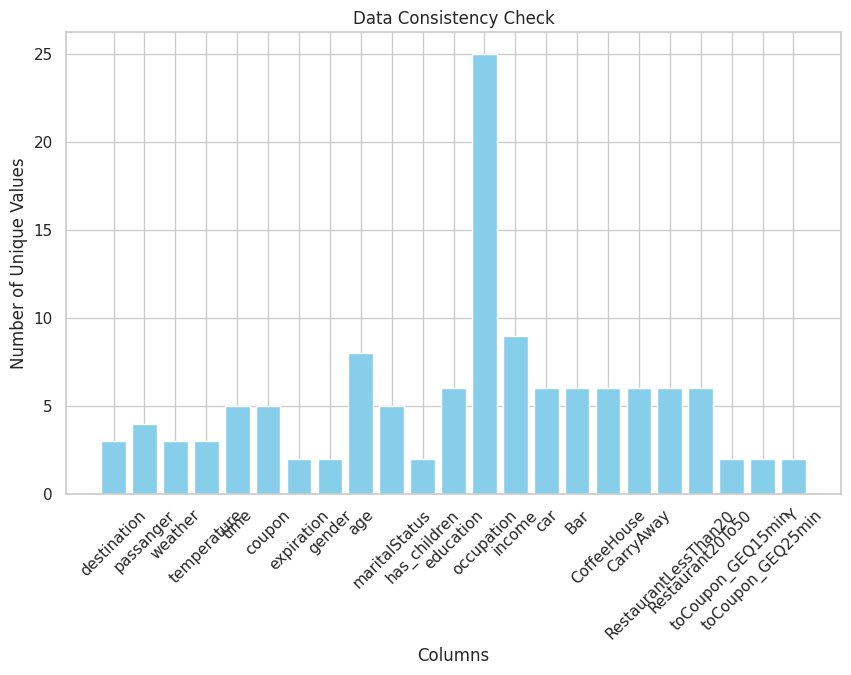

In [ ]:
# Perform data consistency checks:
# ensuring that the data is consistent
# and conforms to the expected format or values

consistency_results = {}
for column in data.columns:
    unique_values = data[column].unique()
    consistency_results[column] = len(unique_values)

# Visualize consistency check results
plt.figure(figsize=(10, 6))
plt.bar(consistency_results.keys(), consistency_results.values(), color='skyblue')
plt.xlabel('Columns')
plt.ylabel('Number of Unique Values')
plt.title('Data Consistency Check')
plt.xticks(rotation=45)
plt.show()

# Missing values

**Supprimer les lignes en double**

In [ ]:
print(f"Shape of dataset before removing duplicates: {data.shape}")
print(f"Number of duplicates: {data.duplicated().sum()}")
data.drop_duplicates(inplace=True)
print(f"Shape of dataset after removing duplicates: {data.shape}")

Shape of dataset before removing duplicates: (12684, 23)
Number of duplicates: 171
Shape of dataset after removing duplicates: (12513, 23)


In [ ]:
data.columns[data.columns.duplicated()]

Index([], dtype='object')

**Vérifiez les valeurs manquantes dans le jeu de données**

In [ ]:
print(f"There are some missing values: {data.isna().values.any()}")

There are some missing values: True


In [ ]:
missing_percentage = data.isna().sum() * 100 / len(data)
dtypes = data.dtypes

df_missing_values = pd.DataFrame({
    'dtype': dtypes,
    'missing_count': data.isna().sum(),
    'missing_percentage': missing_percentage})

df_missing_values[df_missing_values.missing_count != 0]

,dtype,missing_count,missing_percentage
car,object,12405,99.136898
Bar,object,107,0.855111
CoffeeHouse,object,217,1.734196
CarryAway,object,149,1.190762
RestaurantLessThan20,object,128,1.022936
Restaurant20To50,object,189,1.510429


La colonne 'car' est presque vide de valeurs. On doit l'enlever.

Le taux des valeurs manquantes est inférieur à 5% dans les autres colonnes.
On pourrait les imputer aprés avoir consulter un expert.

Les valeurs manquantes sont de types: catégoriel. On pourrait imputer les valeurs manquantes par la catégorie la plus fréquente dans la colonne:
imputation par mode.

In [ ]:
data.drop('car', axis=1, inplace=True)

In [ ]:
# imputation using mode or most frequent value
data = data.fillna(data.mode().iloc[0])

In [ ]:
data.isna().sum()

destination             0
passanger               0
weather                 0
temperature             0
time                    0
coupon                  0
expiration              0
gender                  0
age                     0
maritalStatus           0
has_children            0
education               0
occupation              0
income                  0
Bar                     0
CoffeeHouse             0
CarryAway               0
RestaurantLessThan20    0
Restaurant20To50        0
toCoupon_GEQ15min       0
toCoupon_GEQ25min       0
Y                       0
dtype: int64

# Outliers

Le jeu de données ne contient pratiquement aucune variable quantitative.

Nous ne pourrons donc pas identifier les données aberrantes par la méthode des boxplots.

Nous traçons les boxplots suivants à titre **expérimental**.

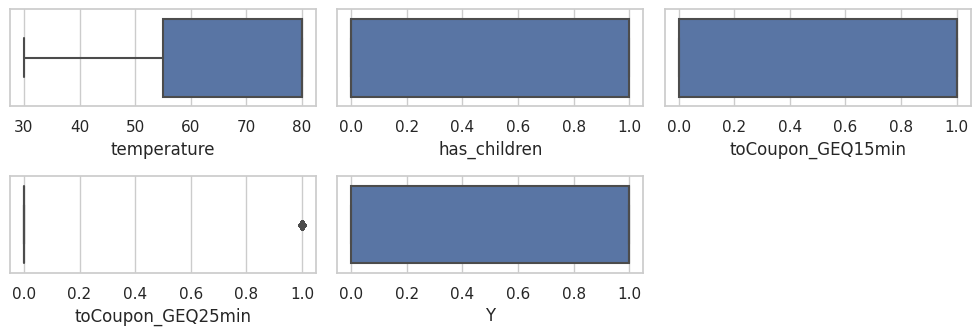

In [ ]:
numeric_columns = data.select_dtypes(include=[np.number]).columns
num_cols = len(numeric_columns)
num_rows = (num_cols - 1) // 5 + 1

# fig, axes = plt.subplots(num_rows, 5, figsize=(20, 4 * num_rows))

# Create a new figure
plt.figure(figsize=(10, 8))

# Loop over the features and create a boxplot for each one
for i, feature in enumerate(numeric_columns):
    plt.subplot(len(numeric_columns), 3, i+1)
    sns.boxplot(x=data[feature])

# Show the plot
plt.tight_layout()
plt.show()

La colonne toCoupon_GEQ25min présente un déséquilibre.

<ipython-input-35-aff1a837be10>:25: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout()


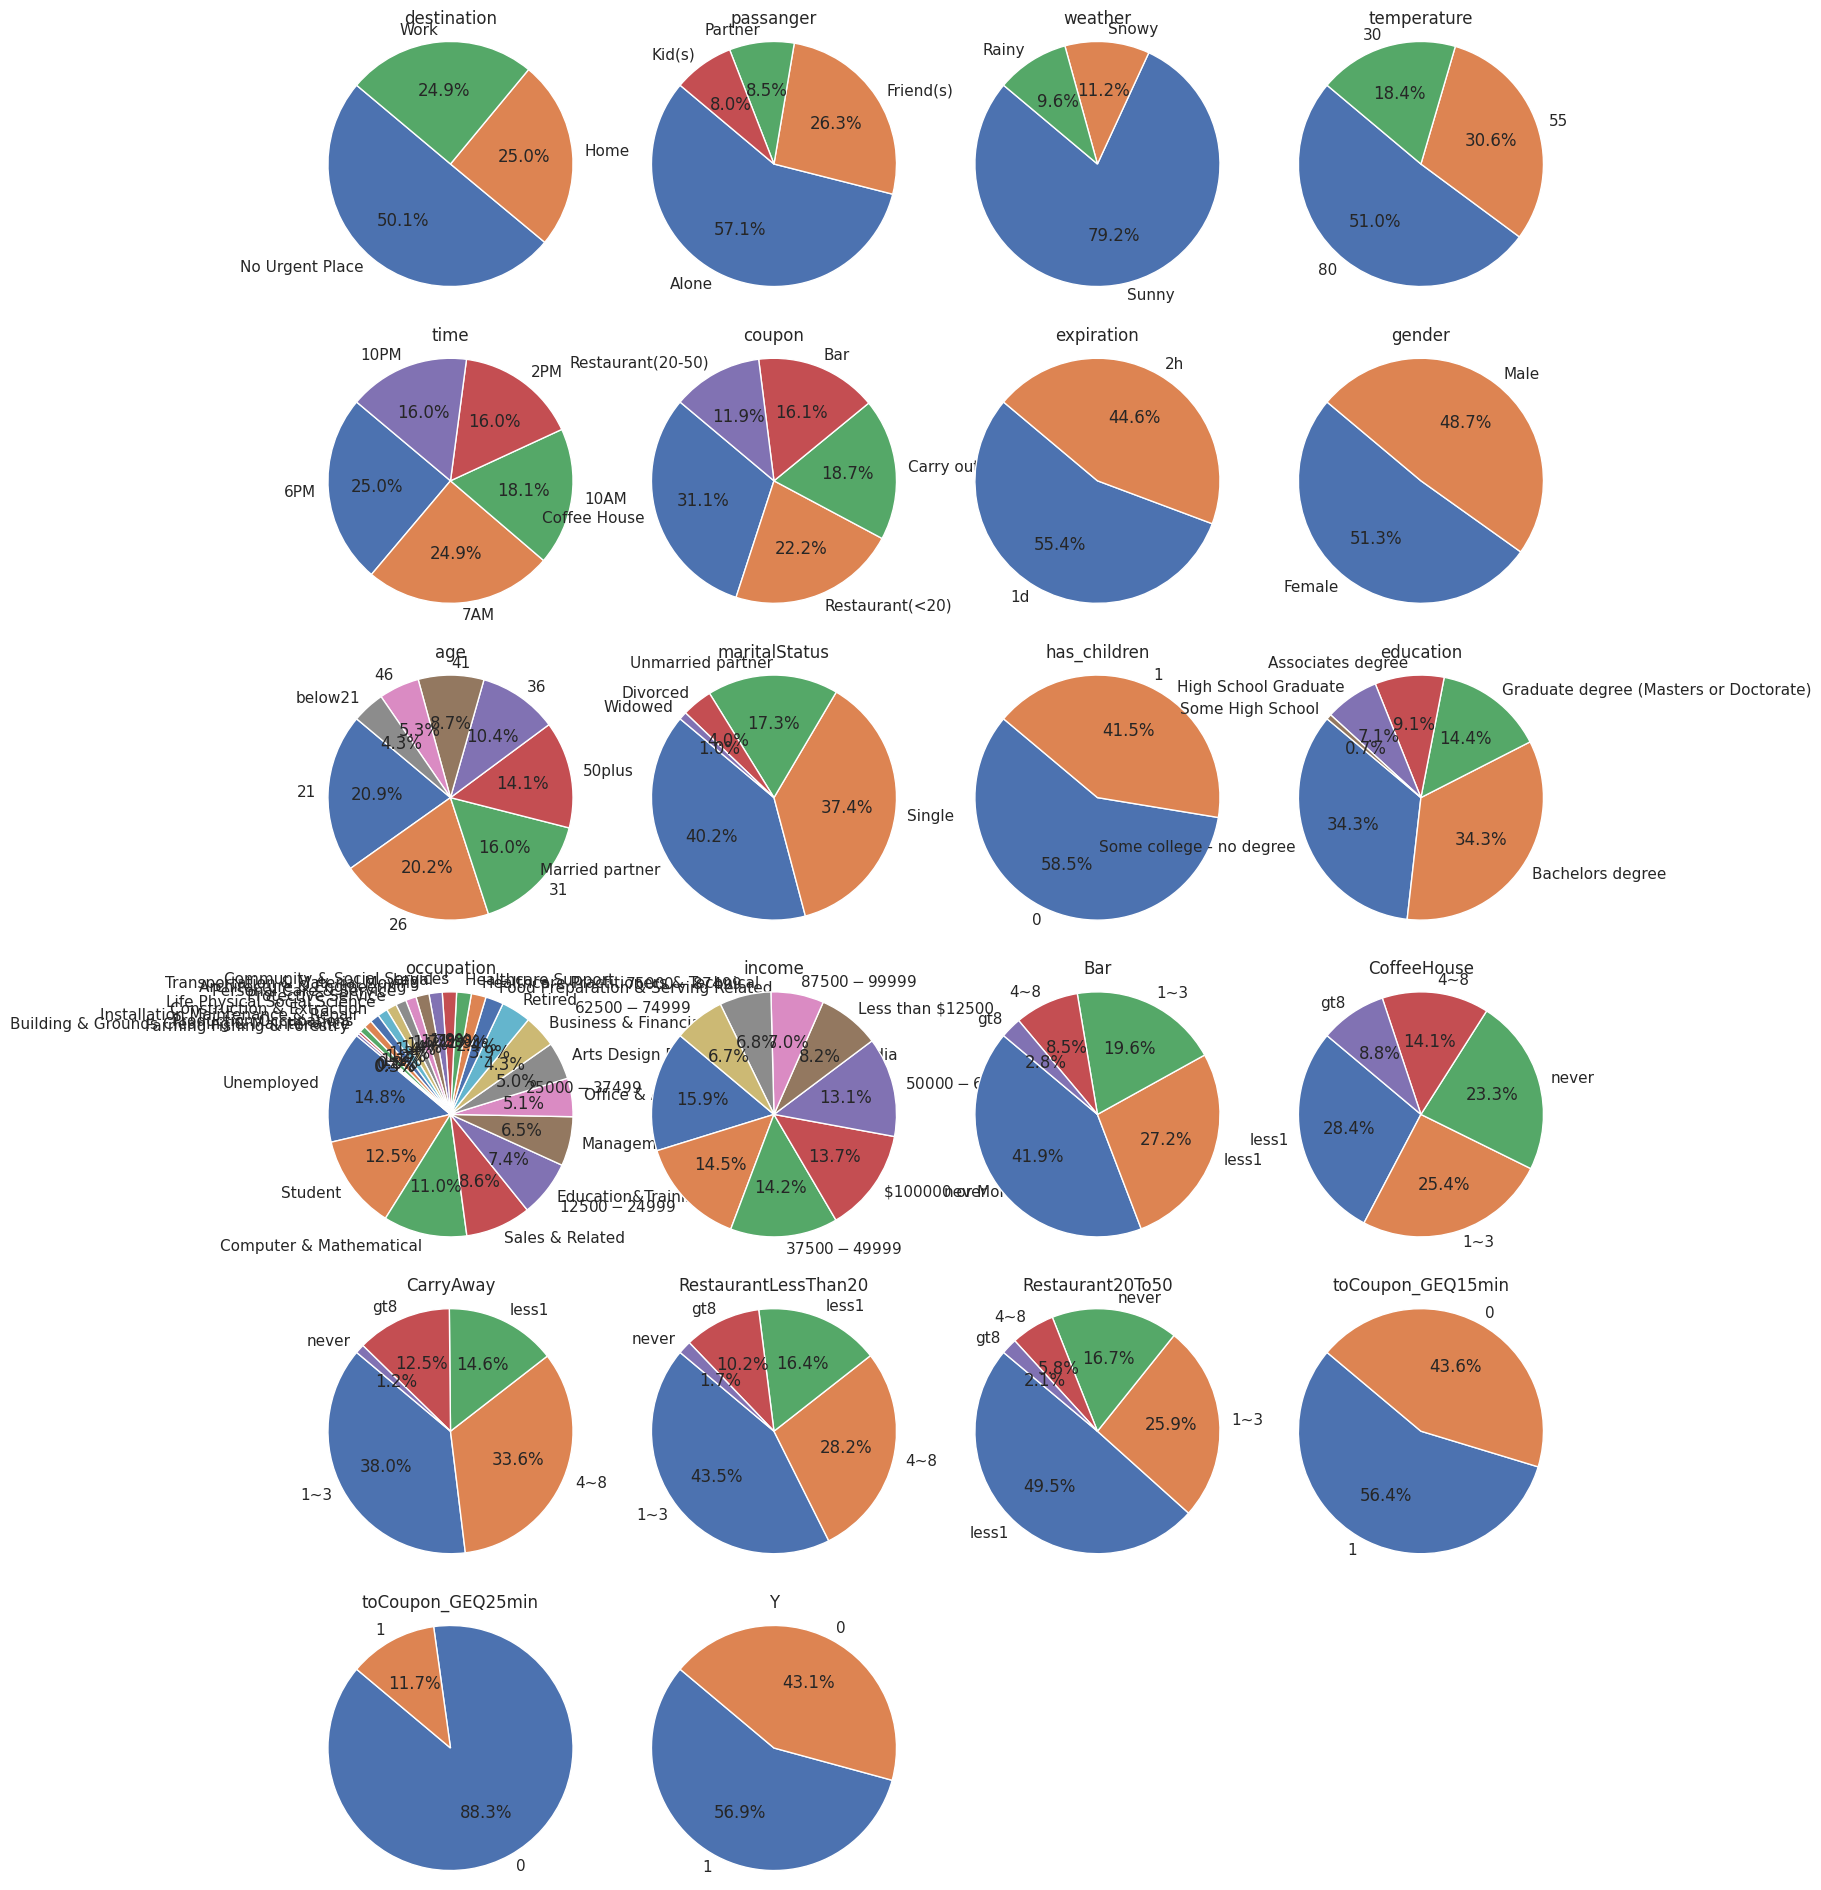

In [ ]:
# checking the existence of dominant categories in a feature.
num_cols = len(data.columns)
num_rows = ceil(num_cols / 4)

fig, axes = plt.subplots(num_rows, 4, figsize=(16, num_rows * 4))

# Flatten the axes for easier indexing
axes = axes.flatten()

for i, column in enumerate(data.columns):
    value_counts = data[column].value_counts()

    axes[i].pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140)

    # Set aspect ratio to be equal, creating a circular pie chart
    axes[i].axis('equal')

    axes[i].set_title(f"{column}")

# Remove excess empty subplots
for j in range(num_cols, num_rows * 4):
    fig.delaxes(axes[j])

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plot
plt.show()

In [ ]:
# For frequency analysis, we can refer to the data visualization plots above
# and check the existence of dominant categories in a feature.
columns = ['occupation']

for column in columns:
    print(f"Frequency analysis for {column}:")
    print(data['occupation'].value_counts())
    print("\n")

Frequency analysis for occupation:
Unemployed                                   1846
Student                                      1559
Computer & Mathematical                      1381
Sales & Related                              1080
Education&Training&Library                    930
Management                                    813
Office & Administrative Support               634
Arts Design Entertainment Sports & Media      622
Business & Financial                          540
Retired                                       489
Food Preparation & Serving Related            296
Healthcare Practitioners & Technical          243
Healthcare Support                            242
Community & Social Services                   235
Legal                                         218
Transportation & Material Moving              217
Architecture & Engineering                    174
Personal Care & Service                       174
Protective Service                            172
Life Physical S

# Train-Test Split

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X = data.drop(columns='Y')
y = data.Y

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(10010, 21) (10010,)
(2503, 21) (2503,)


# Feature Engineering

In [ ]:
# Combine toCoupon_GEQ15min and toCoupon_GEQ25min
# into to_Coupon
to_Coupon = []

for i in range(X_train.shape[0]):
    if (list(X_train['toCoupon_GEQ15min'])[i] == 0):
        to_Coupon.append(0)
    elif (list(X_train['toCoupon_GEQ15min'])[i] == 1) and (list(X_train['toCoupon_GEQ25min'])[i] == 0):
        to_Coupon.append(1)
    else:
        to_Coupon.append(2)

X_train['to_Coupon'] = to_Coupon
print('Unique values:',X_train['to_Coupon'].unique())
print('-'*50)
X_train['to_Coupon'].describe()

Unique values: [0 1 2]
--------------------------------------------------


count    10010.00000
mean         0.67982
std          0.67058
min          0.00000
25%          0.00000
50%          1.00000
75%          1.00000
max          2.00000
Name: to_Coupon, dtype: float64

In [ ]:
to_Coupon = []

for i in range(X_test.shape[0]):
    if (list(X_test['toCoupon_GEQ15min'])[i] == 0):
        to_Coupon.append(0)
    elif (list(X_test['toCoupon_GEQ15min'])[i] == 1) and (list(X_test['toCoupon_GEQ25min'])[i] == 0):
        to_Coupon.append(1)
    else:
        to_Coupon.append(2)

X_test['to_Coupon'] = to_Coupon
print('Unique values:',X_test['to_Coupon'].unique())
print('-'*50)
X_test['to_Coupon'].describe()

Unique values: [1 0 2]
--------------------------------------------------


count    2503.000000
mean        0.685977
std         0.675948
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         2.000000
Name: to_Coupon, dtype: float64

In [ ]:
# combine five features: RestaurantLessThan20, CoffeeHouse, CarryAway, Bar, Restaurant20To50
# into coupon_freq
coupon_freq = []

for i in range(X_train.shape[0]):
    if (list(X_train['coupon'])[i] == 'Restaurant(<20)'):
        coupon_freq.append(list(X_train['RestaurantLessThan20'])[i])
    elif (list(X_train['coupon'])[i] == 'Coffee House'):
        coupon_freq.append(list(X_train['CoffeeHouse'])[i])
    elif (list(X_train['coupon'])[i] == 'Carry out & Take away'):
        coupon_freq.append(list(X_train['CarryAway'])[i])
    elif (list(X_train['coupon'])[i] == 'Bar'):
        coupon_freq.append(list(X_train['Bar'])[i])
    elif (list(X_train['coupon'])[i] == 'Restaurant(20-50)'):
        coupon_freq.append(list(X_train['Restaurant20To50'])[i])

X_train['coupon_freq'] = coupon_freq
print('Unique values:',X_train['coupon_freq'].unique())
print('-'*50)
X_train['coupon_freq'].describe()

Unique values: ['never' '1~3' 'gt8' 'less1' '4~8']
--------------------------------------------------


count     10010
unique        5
top         1~3
freq       3075
Name: coupon_freq, dtype: object

In [ ]:
coupon_freq = []

for i in range(X_test.shape[0]):
    if (list(X_test['coupon'])[i] == 'Restaurant(<20)'):
        coupon_freq.append(list(X_test['RestaurantLessThan20'])[i])
    elif (list(X_test['coupon'])[i] == 'Coffee House'):
        coupon_freq.append(list(X_test['CoffeeHouse'])[i])
    elif (list(X_test['coupon'])[i] == 'Carry out & Take away'):
        coupon_freq.append(list(X_test['CarryAway'])[i])
    elif (list(X_test['coupon'])[i] == 'Bar'):
        coupon_freq.append(list(X_test['Bar'])[i])
    elif (list(X_test['coupon'])[i] == 'Restaurant(20-50)'):
        coupon_freq.append(list(X_test['Restaurant20To50'])[i])

X_test['coupon_freq'] = coupon_freq
print('Unique values:',X_test['coupon_freq'].unique())
print('-'*50)
X_test['coupon_freq'].describe()

Unique values: ['less1' '1~3' 'never' '4~8' 'gt8']
--------------------------------------------------


count     2503
unique       5
top        1~3
freq       773
Name: coupon_freq, dtype: object

In [ ]:
X_train['occupation'].describe()

count          10010
unique            25
top       Unemployed
freq            1457
Name: occupation, dtype: object

In [ ]:
job_df, acc_job, desc_job = get_higher_variable(data, 'occupation')

/usr/local/lib/python3.10/dist-packages/scipy/stats/contingency.py:459: RuntimeWarning: invalid value encountered in double_scalars
  value = phi2 / min(n_cols - 1, n_rows - 1)


In [ ]:
desc_job

Healthcare Support                           69.834711
Construction & Extraction                    68.831169
Healthcare Practitioners & Technical         67.489712
Protective Service                           64.534884
Architecture & Engineering                   63.218391
Production Occupations                       63.207547
Student                                      60.936498
Office & Administrative Support              60.410095
Transportation & Material Moving             59.907834
Building & Grounds Cleaning & Maintenance    59.090909
Food Preparation & Serving Related           58.783784
Management                                   58.671587
Life Physical Social Science                 58.333333
Name: occupation, dtype: float64

In [ ]:
result_df, acc_income, desc_income = get_higher_variable(data, 'income')
desc_income

/usr/local/lib/python3.10/dist-packages/scipy/stats/contingency.py:459: RuntimeWarning: invalid value encountered in double_scalars
  value = phi2 / min(n_cols - 1, n_rows - 1)


$50000 - $62499     59.610706
Less than $12500    59.433040
$25000 - $37499     59.396985
$100000 or More     57.777778
$12500 - $24999     57.426836
$37500 - $49999     56.595265
Name: income, dtype: float64

In [ ]:
# occupation has 25 distinct values (encodage)
# organize occupations by classes
# into occupation_class
occupation_dict = {'Healthcare Support':'High_Acceptance',
                   'Construction & Extraction':'High_Acceptance',
                   'Healthcare Practitioners & Technical':'High_Acceptance',
                   'Protective Service':'High_Acceptance',
                   'Architecture & Engineering':'High_Acceptance',
                   'Production Occupations':'Medium_High_Acceptance',
                    'Student':'Medium_High_Acceptance',
                   'Office & Administrative Support':'Medium_High_Acceptance',
                   'Transportation & Material Moving':'Medium_High_Acceptance',
                    'Building & Grounds Cleaning & Maintenance':'Medium_High_Acceptance',
                   'Management':'Medium_Acceptance',
                   'Food Preparation & Serving Related':'Medium_Acceptance',
                   'Life Physical Social Science':'Medium_Acceptance',
                   'Business & Financial':'Medium_Acceptance',
                   'Computer & Mathematical':'Medium_Acceptance',
                    'Sales & Related':'Medium_Low_Acceptance',
                   'Personal Care & Service':'Medium_Low_Acceptance',
                   'Unemployed':'Medium_Low_Acceptance',
                   'Farming Fishing & Forestry':'Medium_Low_Acceptance',
                   'Installation Maintenance & Repair':'Medium_Low_Acceptance',
                   'Education&Training&Library':'Low_Acceptance',
                    'Arts Design Entertainment Sports & Media':'Low_Acceptance',
                   'Community & Social Services':'Low_Acceptance',
                   'Legal':'Low_Acceptance',
                   'Retired':'Low_Acceptance'}
# occupation_dict
X_train['occupation_class'] = X_train['occupation'].map(occupation_dict)
print('Unique values:',X_train['occupation_class'].unique())
print('-'*50)
X_train['occupation_class'].describe()
# X_train['occupation_class'].value_counts()

Unique values: ['Medium_Acceptance' 'Medium_Low_Acceptance' 'Low_Acceptance'
 'High_Acceptance' 'Medium_High_Acceptance']
--------------------------------------------------


count                     10010
unique                        5
top       Medium_Low_Acceptance
freq                       2596
Name: occupation_class, dtype: object

In [ ]:
X_test['occupation_class'] = X_test['occupation'].map(occupation_dict)
print('Unique values:',X_test['occupation_class'].unique())
print('-'*50)
X_test['occupation_class'].describe()
# X_test['occupation_class'].value_counts()

Unique values: ['High_Acceptance' 'Medium_Acceptance' 'Low_Acceptance'
 'Medium_High_Acceptance' 'Medium_Low_Acceptance']
--------------------------------------------------


count                      2503
unique                        5
top       Medium_Low_Acceptance
freq                        680
Name: occupation_class, dtype: object

In [ ]:
# Remove combined features
X_train = X_train.drop(['toCoupon_GEQ15min','toCoupon_GEQ25min','Bar','CoffeeHouse','CarryAway','RestaurantLessThan20','Restaurant20To50','occupation'], axis=1)
X_test = X_test.drop(['toCoupon_GEQ15min','toCoupon_GEQ25min','Bar','CoffeeHouse','CarryAway','RestaurantLessThan20','Restaurant20To50','occupation'], axis=1)

print('X_train:',X_train.shape,'\nX_test:',X_test.shape)
print('-' * 50)
print(X_train.columns.values)

X_train: (10010, 16) 
X_test: (2503, 16)
--------------------------------------------------
['destination' 'passanger' 'weather' 'temperature' 'time' 'coupon'
 'expiration' 'gender' 'age' 'maritalStatus' 'has_children' 'education'
 'income' 'to_Coupon' 'coupon_freq' 'occupation_class']


# Encoding

Il est important de choisir le codage approprié en fonction de la nature des données et de l'algorithme d'apprentissage automatique.

Par exemple, le 'one-hot encoding' est souvent utilisé pour les modèles arborescents, tandis que le 'frequencey encoding' peut convenir aux modèles linéaires.

In [ ]:
for column in X_train.columns:
    unique_values = X_train[column].unique()
    print(f"{column}: {list(unique_values)}")

destination: ['No Urgent Place', 'Home', 'Work']
passanger: ['Partner', 'Kid(s)', 'Alone', 'Friend(s)']
weather: ['Sunny', 'Rainy', 'Snowy']
temperature: [80, 55, 30]
time: ['10AM', '2PM', '10PM', '6PM', '7AM']
coupon: ['Restaurant(20-50)', 'Restaurant(<20)', 'Coffee House', 'Carry out & Take away', 'Bar']
expiration: ['2h', '1d']
gender: ['Female', 'Male']
age: ['36', 'below21', '26', '31', '21', '46', '41', '50plus']
maritalStatus: ['Married partner', 'Unmarried partner', 'Single', 'Divorced', 'Widowed']
has_children: [0, 1]
education: ['Bachelors degree', 'Some college - no degree', 'Graduate degree (Masters or Doctorate)', 'Associates degree', 'Some High School', 'High School Graduate']
income: ['$50000 - $62499', '$87500 - $99999', '$37500 - $49999', 'Less than $12500', '$12500 - $24999', '$25000 - $37499', '$75000 - $87499', '$100000 or More', '$62500 - $74999']
to_Coupon: [0, 1, 2]
coupon_freq: ['never', '1~3', 'gt8', 'less1', '4~8']
occupation_class: ['Medium_Acceptance', 'Medi

In [ ]:
X_train.select_dtypes('int64').nunique()

temperature     3
has_children    2
to_Coupon       3
dtype: int64

Nous utiliserons un encodage
**Ordinal** pour les colonnes :
   
*   temperature
*   time
*   expiration
*   age
*   education
*   income
*   coupon_freq

et **one-hot encoding** pour le reste les colonnes :
['destination', 'passanger', 'weather', 'maritalStatus', 'coupon']

La colonne target est binaire (LabelEncoded)

## Ordinal Encoding

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

In [ ]:
# Mapping for ordinal encoding
ordinal_encoder = {
    # 'temperature': {
    #     '30': 1, '55': 2, '80': 3,
    # },
    'coupon_freq': {
        'never': 1, 'less1': 2, '1~3': 3, '4~8': 4, 'gt8': 5
    },
    'gender': {
        'Male': 1, 'Female': 0
    },
    'expiration': {
        '1d': 1, '2h': 0
    },
    'time': {
        '7AM': 1, '10AM': 2, '2PM': 3, '6PM': 4, '10PM': 5
    },
    'education': {
        'Some High School': 1, 'High School Graduate': 2, 'Some college - no degree': 3,
        'Associates degree': 5, 'Bachelors degree': 6, 'Graduate degree (Masters or Doctorate)': 7
    },
    'income': {
        'Less than $12500': 1, '$12500 - $24999': 2, '$25000 - $37499': 3, '$37500 - $49999': 4,
        '$50000 - $62499': 5, '$62500 - $74999': 6, '$75000 - $87499': 7, '$87500 - $99999': 8,
        '$100000 or More': 10
    },
    'age': {
        'below21': 1, '21': 2, '26': 3, '31': 4, '36': 5, '41': 6, '46': 6, '50plus': 7
    }
}

# Loop through the train and test datasets
for data in [X_train, X_test]:
    # Feature engineering
    data['high_income'] = data['income'].isin(desc_income.index.tolist()).astype(int)

    # Apply ordinal encoding
    for col in ordinal_encoder:
        if isinstance(col, tuple):
            for col_spec in col:
                data[col_spec] = data[col_spec].map(ordinal_encoder[col])
        else:
            data[col] = data[col].map(ordinal_encoder[col])


## One-Hot encoding

In [ ]:
# List of columns to one-hot encode
one_hot_target = ['destination', 'passanger', 'weather', 'maritalStatus', 'coupon']

In [ ]:
def one_hot_encoding(df, col_li):
  categories = ['chat', 'chien', 'oiseau', 'poisson']

# Initialisez l'encodeur one-hot
  encoder = OneHotEncoder(sparse=False)

# Ajustez et transformez les données
  one_hot_encoded = encoder.fit_transform([[cat] for cat in categories])
  one_hot = pd.get_dummies(df[col_li])
 # df = pd.concat([df, one_hot], axis = 1)
  #df = df.drop(columns = col_li)
  return df

In [ ]:
X_train = one_hot_encoding(X_train, one_hot_target)
X_test = one_hot_encoding(X_test, one_hot_target)

In [ ]:
!pip install category_encoders

In [ ]:
from category_encoders import MEstimateEncoder

In [ ]:
def target_encoding(X_train,X_test,y_train,col):
  encoder = MEstimateEncoder()
  X_train[col] = encoder.fit_transform(X_train[col], y_train)
  X_test[col] = encoder.transform(X_test[col])
  return X_train, X_test

# perform target encoding on the 'occupation_class' column in the training and test datasets
# to capture the relationship between the categorical feature 'occupation' and the target variable.
X_train, X_test = target_encoding(X_train, X_test, y_train, 'occupation_class')

Target encoding is often used to handle categorical features in a way that incorporates information about the target variable into the encoding, potentially improving the performance of machine learning models.

In [ ]:
# renaming columns
def rename(df):
    column_replacements = {
        'passanger' : 'passenger',
        'passanger_Friend(s)': 'passenger_Friends',
        'passanger_Kid(s)': 'passenger_Kids',
        'coupon_Carry out & Take away': 'coupon_CarryOut_TakeAway',
        'coupon_Restaurant(<20)': 'coupon_Restaurant20'
    }

    df.columns = df.columns.to_series().replace(column_replacements, regex=True)
    return df

X_train = rename(X_train)
X_test = rename(X_test)

In [ ]:
X_train

,temperature,time,expiration,gender,age,has_children,education,income,to_Coupon,coupon_freq,...,maritalStatus_Divorced,maritalStatus_Married partner,maritalStatus_Single,maritalStatus_Unmarried partner,maritalStatus_Widowed,coupon_Bar,coupon_CarryOut_TakeAway,coupon_Coffee House,coupon_Restaurant(20-50),coupon_Restaurant(<20)
4418,80,2,0,0,5,0,6,5,0,1,...,0,1,0,0,0,0,0,0,1,0
1797,80,3,1,1,5,1,3,8,0,3,...,0,0,0,1,0,0,0,0,0,1
11179,55,5,0,0,1,1,3,4,0,5,...,0,0,0,1,0,0,0,1,0,0
6011,80,4,1,0,3,0,6,1,0,3,...,0,0,1,0,0,0,0,1,0,0
9531,30,1,1,1,4,0,6,2,1,3,...,0,0,0,1,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9756,80,5,1,0,7,1,6,10,0,3,...,0,1,0,0,0,0,0,0,0,1
7523,30,1,1,0,6,1,3,1,2,2,...,0,0,0,1,0,0,0,0,1,0
11170,55,5,0,0,1,1,3,4,1,1,...,0,0,0,1,0,1,0,0,0,0
6532,80,1,0,1,1,0,3,1,0,4,...,0,0,1,0,0,0,0,1,0,0


**Impact sur les modèles :**

Différentes stratégies de codage peuvent avoir des impacts variables sur différents types de modèles.
Les modèles arborescents (arbres de décision, forêts aléatoires) peuvent bien gérer les deux types de codage car ils divisent les données en fonction des valeurs des caractéristiques et ne supposent pas de relations linéaires.

Les modèles linéaires peuvent être influencés par le choix du codage, surtout si le codage ordinal implique une relation linéaire entre les catégories.


**Normalisation :**

Après le codage, il est essentiel de déterminer si une normalisation est nécessaire pour les caractéristiques numériques. Ceci est plus pertinent pour les modèles sensibles à l'échelle des caractéristiques d'entrée, tels que la régression linéaire ou les k voisins les plus proches.


**Interprétabilité :**

Le choix de l’encodage peut affecter l’interprétabilité de votre modèle. Par exemple, avec le codage ordinal, le modèle suppose une relation linéaire entre les valeurs ordinales, qui peut ou non refléter la véritable nature des données sous-jacentes.

# Feature Selection

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

In [ ]:
a Q# Specify the number of features to select (k)
k_best = 5

# Create SelectKBest object
selector = SelectKBest(chi2, k=k_best)

# Fit the selector to the data
X_train_selected = selector.fit_transform(X_train, y_train)

# Get the selected features
selected_features = X_train.columns[selector.get_support()]

# Print the selected features
print(f"Selected Features: {selected_features}")

# transform X_test as well
X_test_selected = selector.transform(X_test)

Selected Features: Index(['temperature', 'coupon_freq', 'coupon_Bar', 'coupon_CarryOut_TakeAway',
       'coupon_Restaurant(<20)'],
      dtype='object')


In [ ]:
# Get the scores
feature_scores = selector.scores_

# Print the scores
print("Feature Scores:")
for feature, score in zip(X_train.columns, feature_scores):
    print(f"{feature}: {score}")

# Print a summary
summary_df = pd.DataFrame({'Feature': X_train.columns, 'Score': feature_scores})
summary_df = summary_df.sort_values(by='Score', ascending=False).reset_index(drop=True)
print("\nFeature Selection Summary:")
print(summary_df.head(k_best))

Feature Scores:
temperature: 259.3657785557968
time: 4.908442521246371
expiration: 79.8905400589862
gender: 10.023173193415339
age: 38.79891974215962
has_children: 13.16994333978623
education: 18.804312040883445
income: 13.960697980527547
to_Coupon: 87.98420269156804
coupon_freq: 475.83572042918706
occupation_class: 0.5147916432514299
high_income: 7.031870462783856
destination_Home: 29.95911762356588
destination_No Urgent Place: 83.56287873160929
destination_Work: 56.35377438936321
passenger_Alone: 44.59349963567714
passenger_Friend(s): 116.14597304242606
passenger_Kid(s): 15.03266895417689
passenger_Partner: 4.03182383097968
weather_Rainy: 37.86462501756765
weather_Snowy: 47.54554352423817
weather_Sunny: 22.203802251920287
maritalStatus_Divorced: 4.044351000524608
maritalStatus_Married partner: 10.432446323673028
maritalStatus_Single: 19.441061008888063
maritalStatus_Unmarried partner: 0.0410820914180413
maritalStatus_Widowed: 1.75177484977189
coupon_Bar: 161.48212545952362
coupon_Car

# Normalization

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Create a MinMaxScaler object
scaler = MinMaxScaler()

# Reshape the 'Temperature' column in X_train and X_test to a 2D array
X_train['temperature'] = scaler.fit_transform(X_train[['temperature']])
X_test['temperature'] = scaler.transform(X_test[['temperature']])

In [ ]:
X_train['temperature']

4418     1.0
1797     1.0
11179    0.5
6011     1.0
9531     0.0
        ... 
9756     1.0
7523     0.0
11170    0.5
6532     1.0
10974    0.0
Name: temperature, Length: 10010, dtype: float64

# PCA

**Standardizing** the data is recommended before PCA but our dataset is categoric.

**La PCA est plutôt adaptée à des données décrites par des variables quantitatives**

Les jeux de données catégorielles, y compris ceux qui ont été codées à l’aide d’un codage one-hot ou d’un codage ordinal, n’ont généralement pas besoin d’être standardisées. Ces entités représentent des catégories, et les distances ou magnitudes entre les catégories n'ont pas la même signification qu'elles le sont pour les entités numériques.

In [ ]:
from sklearn.decomposition import PCA

In [ ]:
pca = PCA()
X_train_pca = pca.fit_transform(X_train)

Explained Variance Ratio:
[3.76933902e-01 1.59752053e-01 1.11908988e-01 1.03723486e-01
 6.40386175e-02 3.01750231e-02 2.17982056e-02 1.79154310e-02
 1.46242956e-02 1.13829464e-02 1.07070115e-02 1.03601332e-02
 9.53347079e-03 8.62667375e-03 6.93850146e-03 6.45557650e-03
 5.89059379e-03 5.52043945e-03 4.86826780e-03 4.76690831e-03
 3.52550271e-03 2.93454308e-03 2.67810666e-03 2.25868915e-03
 2.02290698e-03 5.50924483e-04 1.08802101e-04 7.43371048e-32
 2.08356417e-33 2.08356417e-33 2.08356417e-33 2.08356417e-33]

Cumulative Explained Variance:
[0.3769339  0.53668595 0.64859494 0.75231843 0.81635705 0.84653207
 0.86833028 0.88624571 0.90087    0.91225295 0.92295996 0.93332009
 0.94285356 0.95148024 0.95841874 0.96487432 0.97076491 0.97628535
 0.98115362 0.98592052 0.98944603 0.99238057 0.99505868 0.99731737
 0.99934027 0.9998912  1.         1.         1.         1.
 1.         1.        ]

Optimal Number of Components for 0.95 Explained Variance: 14


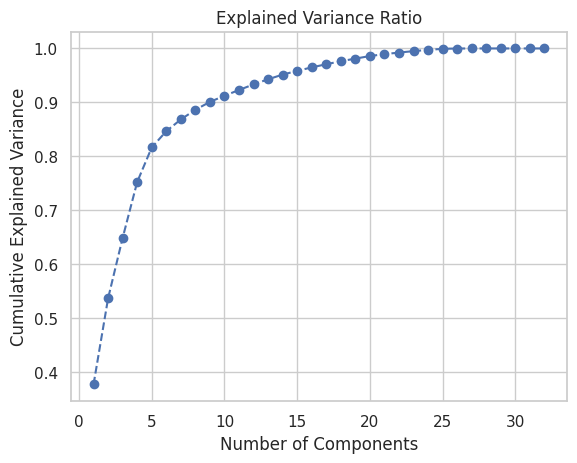

In [ ]:
explained_variance_ratio = pca.explained_variance_ratio_
print("Explained Variance Ratio:")
print(explained_variance_ratio)

# Print cumulative explained variance
cumulative_explained_variance = explained_variance_ratio.cumsum()
print("\nCumulative Explained Variance:")
print(cumulative_explained_variance)

# Determine the optimal number of components based on a desired explained variance threshold
desired_explained_variance = 0.95
optimal_components = 0
for i, value in enumerate(cumulative_explained_variance, 1):
    if value >= desired_explained_variance:
        optimal_components = i
        break
print(f"\nOptimal Number of Components for {desired_explained_variance} Explained Variance: {optimal_components}")

# Visualize the explained variance ratio
plt.plot(range(1, len(explained_variance_ratio) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance Ratio')
plt.show()

# Export Data

In [ ]:
# Export X_train and y_train
train_data = pd.concat([X_train, y_train], axis=1)
train_data.to_csv('train_data.csv', index=False)

# Export X_test and y_test
test_data = pd.concat([X_test, y_test], axis=1)
test_data.to_csv('test_data.csv', index=False)

# Decision Tree

In [ ]:
import sklearn as sk
from math import sqrt
from sklearn import metrics
from sklearn.metrics import classification_report, mean_squared_error, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [ ]:
DTC = DecisionTreeClassifier().fit(X_train, y_train)

#Predict the response for test dataset
y_pred_DTC = DTC.predict(X_test)
score_DTC = DTC.score(X_test, y_test)

print('The accuracy of the Decision tree model is ', score_DTC)
targets = ['<=50k' , '>50k']
print(classification_report(y_test, y_pred_DTC, target_names=targets))

#calculate RMSE
print('RMSE =', sqrt(mean_squared_error(y_test, y_pred_DTC)))

The accuracy of the Decision tree model is  0.6791849780263683
              precision    recall  f1-score   support

       <=50k       0.62      0.65      0.64      1080
        >50k       0.72      0.70      0.71      1423

    accuracy                           0.68      2503
   macro avg       0.67      0.68      0.67      2503
weighted avg       0.68      0.68      0.68      2503

RMSE = 0.5664053512932515


In [ ]:
cm_DTC = confusion_matrix(y_test,y_pred_DTC)

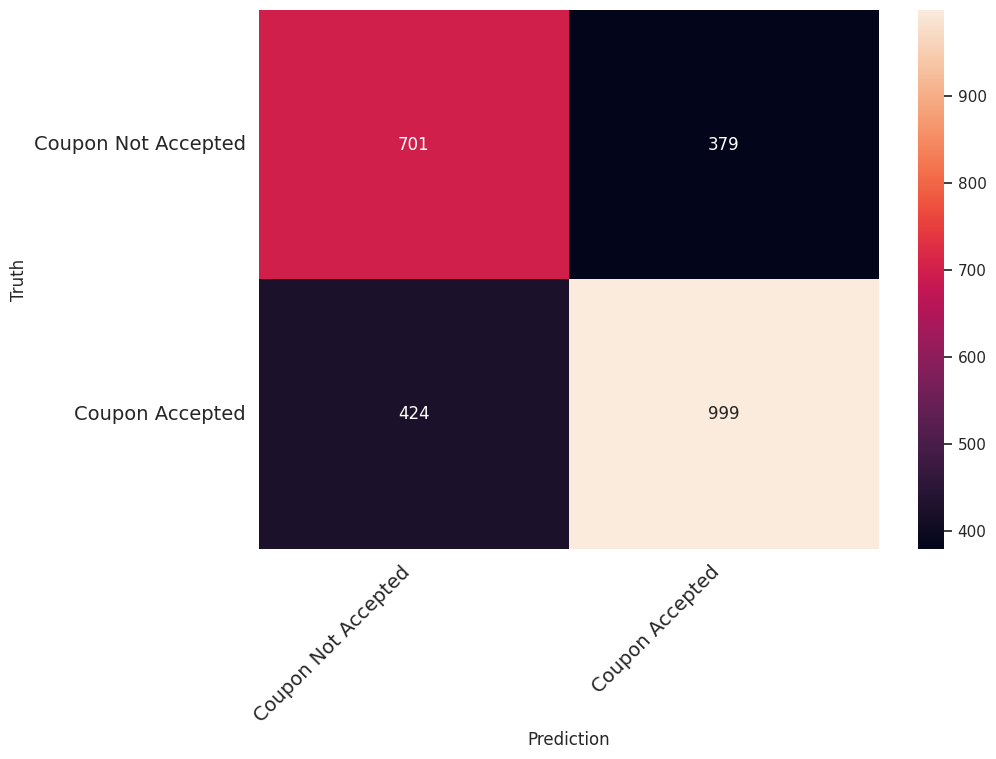

In [ ]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Truth')
    plt.xlabel('Prediction')

print_confusion_matrix(cm_DTC,["Coupon Not Accepted", "Coupon Accepted"])